In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

## Import and reformat data

In [2]:
#import distance matrix, atchison no blanks
aitch = pd.read_csv('../data/SRS_aitchison_distance_matrix.tsv', sep='\t', index_col=0)

In [3]:
#melt distance matrix and convert to pandas dataframe 
meltaitch = aitch.unstack()
df = pd.DataFrame(meltaitch)
df.reset_index(inplace=True)
df.columns=['col1','col2','distance']

# drop sample-sample distances that equal 0
df = df[df['col1']!=df['col2']]
# drop reverse duplicates
df['check_string'] = df.apply(lambda row: ''.join(sorted([row['col1'], row['col2']])), axis=1)
test = df.drop_duplicates('check_string')

In [4]:
#split sample names to break down comparisons, and merge into one dataframe
df1 = df.col1.str.split('.',expand=True)
df1.columns=['subj1','timepoint1','processing1']

df2 = df.col2.str.split('.',expand=True)
df2.columns=['subj2','timepoint2','processing2']

dff = pd.concat([df1, df2, df], axis=1)

#add in sample
dff['samp1'] = dff['col1'].str[0:4]
dff['samp2'] = dff['col2'].str[0:4]

#add in treatment group
dff['tx1'] = dff['samp1'].str[0:1]
dff['tx2'] = dff['samp2'].str[0:1]

#rename PMA-tx samples (left blank in sequencing name)
dff['processing1'].fillna(value='PMA', inplace=True)
dff['processing2'].fillna(value='PMA', inplace=True)

## Compare average distance within a given participant across treatments

In [5]:
# subset out distances among samples from the same subject
ss = dff[(dff['subj1']==dff['subj2'])]
# rename treatments from variable code to desscription
ss['tx'] = ss['tx1'].replace({'A':'water','B':'antiseptic mw', 'C':'alcohol-free mw', 'D':'soda'})
ss['tx'].unique()

/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array(['alcohol-free mw', 'water', 'antiseptic mw', 'soda'], dtype=object)

In [6]:
# subset out samples procccesed with PMA versus raw
ssp = ss[(ss['processing1']==ss['processing2'])&
         (ss['processing1']=='PMA')]
ssr = ss[(ss['processing1']==ss['processing2'])&
         (ss['processing1']=='raw')]

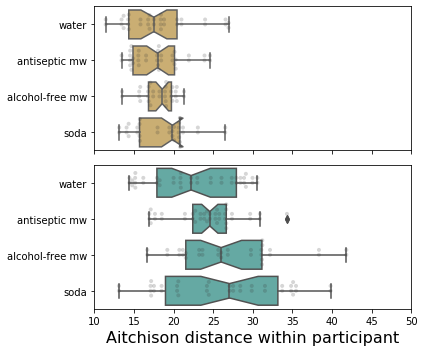

In [7]:
# plot
order=['water', 'antiseptic mw', 'alcohol-free mw', 'soda'] # choose order of txs
fig, (ax1, ax2) = plt.subplots(2, sharex=True) # make 2 side by side plots
fig.set_size_inches(6,5)
# plot data
sns.boxplot(y='tx',x='distance', data=ssr, palette=['#d8b365'], ax=ax1, order=order, notch=True)
sns.boxplot(y='tx',x='distance', data=ssp, ax=ax2, palette=['#5ab4ac'], order=order, notch=True)

sns.swarmplot(y='tx',x='distance', data=ssr, ax=ax1, order=order, color='.2', alpha=.2, size=4)
sns.swarmplot(y='tx',x='distance', data=ssp, ax=ax2, order=order, color='.2', alpha=.2, size=4)

# set labels 
ax1.set_xlabel('')
ax2.set_xlabel('Aitchison distance within participant', fontsize=16)
ax1.set_ylabel('')
ax2.set_ylabel('')
# adjust scale
ax1.set_xlim(10,50)
ax2.set_xlim(10,50)
plt.tight_layout()
# save
fig.savefig('/Users/lisamarotz/Dropbox/Lisa_stuff/Thesis/publications/Saliva_quant/Figures/Figure4_response/aitchison_dist_raw_v_PMA_v_tx.pdf',
            bbox_inches='tight')

In [8]:
# Calculate one way ANOVA with Tukey HSD multiple comparison in PMA-treated (live) samples
mc = MultiComparison(ssp['distance'], ssp['tx1'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B   1.8862 0.4933 -1.5814 5.3539  False
     A      C   4.6034 0.0074  0.9374 8.2693   True
     A      D   3.6557 0.0415  0.0979 7.2134   True
     B      C   2.7172 0.2219 -0.9488 6.3831  False
     B      D   1.7695 0.5614 -1.7883 5.3272  False
     C      D  -0.9477    0.9  -4.699 2.8036  False
---------------------------------------------------


In [9]:
# Calculate one way ANOVA with Tukey HSD multiple comparison in raw (total) samples
mc = MultiComparison(ssr['distance'], ssr['tx1'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B  -0.2229    0.9 -2.3651 1.9192  False
     A      C  -0.0495    0.9 -2.2557 2.1568  False
     A      D   0.6314  0.861 -1.5412 2.8039  False
     B      C   0.1735    0.9 -2.0028 2.3498  False
     B      D   0.8543 0.7037 -1.2879 2.9965  False
     C      D   0.6808 0.8348 -1.5254 2.8871  False
---------------------------------------------------


## Identify timepoint driving variation in PMA-treated samples

In [10]:
# create function to label different distance types
def f(row):
    if ((row['timepoint1']!='3')&(row['timepoint2']!='3')):
           val = "t1-t2"
    elif ((row['timepoint1']!='2')&(row['timepoint2']!='2')):
           val = "t1-t3"
    else:
        val = "t2-t3"
    return val

ssr['cat2'] = ssr.apply(f, axis=1)
ssp['cat2'] = ssp.apply(f, axis=1)

/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [11]:
# sort values for plotting below
ssp.sort_values(by='cat2', inplace=True)

/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


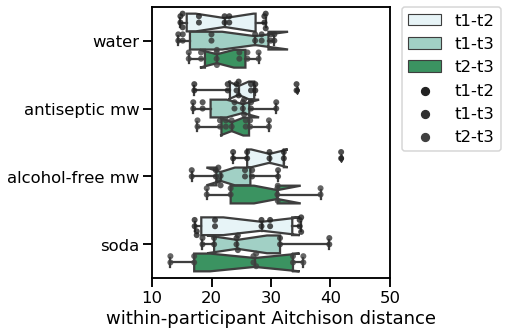

In [15]:
# plot
order=['water', 'antiseptic mw', 'alcohol-free mw', 'soda'] # choose order of txs
fig, ax1 = plt.subplots() # make 2 side by side plots
fig.set_size_inches(6,5)
sns.set_context('talk')
# plot data
sns.boxplot(y='tx',x='distance', data=ssp, ax=ax1, hue='cat2', palette=['#e5f5f9','#99d8c9','#2ca25f'],order=order, notch=True)
sns.swarmplot(y='tx',x='distance', data=ssp, ax=ax1, order=order, hue='cat2', color='.25',alpha='0.8', size=6, dodge=True)

# set labels 
ax1.set_ylabel('')
ax1.set_xlabel('within-participant Aitchison distance')
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
# adjust scale
ax1.set_xlim(10,50)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.savefig('/Users/lisamarotz/Dropbox/Lisa_stuff/Thesis/publications/Saliva_quant/Figures/FigureS4_time_v_beta/Aitchison_distance_across_timepoints_by_group.pdf',
            bbox_inches='tight')

In [16]:
# divide up each of the 4 treatment groups for statistical analysis of beta-diversity across across timepoint
wp = ssp[ssp['tx']=='water']
asmp = ssp[ssp['tx']=='antiseptic mw']
afmp = ssp[ssp['tx']=='alcohol-free mw']
sp = ssp[ssp['tx']=='soda']

In [17]:
# Calculate one way ANOVA with Tukey HSD multiple comparison in live betea-diversity across timepoints 
# in water treatment group
mc = MultiComparison(wp['distance'], wp['cat2'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 t1-t2  t1-t3   2.1261 0.5775 -3.0593 7.3114  False
 t1-t2  t2-t3   0.5462    0.9 -4.6391 5.7316  False
 t1-t3  t2-t3  -1.5799 0.7237 -6.7652 3.6055  False
---------------------------------------------------


In [18]:
# Calculate one way ANOVA with Tukey HSD multiple comparison in live betea-diversity across timepoints 
# in water antiseptic mouthwash group
mc = MultiComparison(asmp['distance'], asmp['cat2'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 t1-t2  t1-t3   -1.332  0.699 -5.4622 2.7983  False
 t1-t2  t2-t3  -1.4464 0.6605 -5.5767 2.6838  False
 t1-t3  t2-t3  -0.1145    0.9 -4.2447 4.0158  False
---------------------------------------------------


In [19]:
# Calculate one way ANOVA with Tukey HSD multiple comparison in live betea-diversity across timepoints 
# in alcohol-free mouthwash treatment group
mc = MultiComparison(afmp['distance'], afmp['cat2'])
result = mc.tukeyhsd()
print(result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
 t1-t2  t1-t3  -7.2808 0.0173 -13.4151 -1.1465   True
 t1-t2  t2-t3  -2.0752  0.709   -8.701  4.5506  False
 t1-t3  t2-t3   5.2055 0.1088  -0.9288 11.3399  False
-----------------------------------------------------


In [20]:
# Calculate one way ANOVA with Tukey HSD multiple comparison in live betea-diversity across timepoints 
# in soda treatment group
mc = MultiComparison(sp['distance'], sp['cat2'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
 t1-t2  t1-t3   0.2754   0.9 -7.2566 7.8074  False
 t1-t2  t2-t3  -0.5577   0.9 -8.0898 6.9743  False
 t1-t3  t2-t3  -0.8331   0.9 -8.6495 6.9832  False
--------------------------------------------------
